In [19]:
from helpers import Helpers

ImportError: cannot import name Helpers

In [3]:
import pyopencl as cl
import numpy as np
import pylab

import scipy
import PIL
import PIL.Image as im
from scipy import ndimage
from PIL import ImageEnhance
import random
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [152]:
def read_img_large_small(imgpath = '../test_large2.JPG'):
    # Read in images, im_orig is a large image, im is a small one.
    im_orig = scipy.misc.imread(imgpath,flatten=True)
    # Use a small image to test (by 12*12)
    im_small = np.array([im_orig[i][::12] for i in range(len(im_orig)) if i%12==0])
    return im_orig, im_small

def histogram(im):
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), histogram)
    plt.xlim([0,256])
    plt.show()
    #return histogram

def hist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist)
    plt.xlim([0,256])

def cumhist(im_input):
    im = im_input.astype(int)
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            if j<0:
                j=0
            if j>255:
                j=255
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    plt.bar(range(256), np.cumsum(histogram))
    plt.xlim([0,256])
    plt.ylim([0,1])
    plt.show()
    
def cumhist_np(im_input,nbr_bins=256):
    im = im_input.astype(int)
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    plt.bar(bins[:-1], imhist.cumsum())
    plt.xlim([0,256])
    plt.ylim([0,1])
    
def round_up(global_size, group_size):
    r = global_size % group_size
    if r == 0:
        return global_size
    return global_size + group_size - r

def normalize(img):
    return img/(np.max(img)-np.min(img))*256

In [22]:
show = lambda img: plt.imshow(img.astype(int))
gshow = lambda img: plt.imshow(img.astype(int), cmap = plt.get_cmap('gray'))
rgb2gray = lambda rgb: np.dot(rgb[...,:3], [0.299, 0.587, 0.144])

In [21]:
im_orig, im_small = read_img_large_small()

In [23]:
im_orig.shape

(3648, 5472)

In [24]:
im_small.shape

(304, 456)

##0. Original images

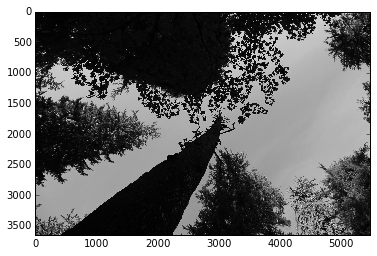

In [28]:
gshow(im_orig)
scipy.misc.imsave('im_orig.jpg', im_orig)

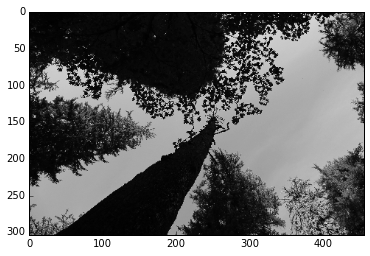

In [29]:
gshow(im_small)
scipy.misc.imsave('im_small.jpg', im_small)

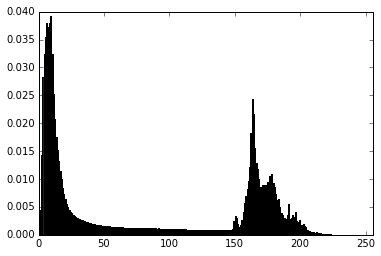

CPU times: user 6.38 s, sys: 105 ms, total: 6.48 s
Wall time: 6.53 s


In [66]:
%%time
histogram(im_orig.astype(int))

CPU times: user 644 ms, sys: 184 ms, total: 828 ms
Wall time: 840 ms


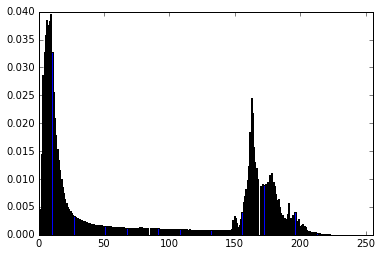

In [67]:
%%time
hist_np(im_orig.astype(int))

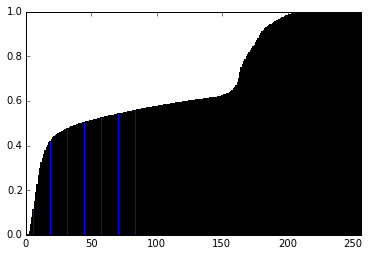

CPU times: user 8.9 s, sys: 230 ms, total: 9.13 s
Wall time: 9.12 s


In [64]:
%%time
cumhist(im_orig.astype(int))

CPU times: user 609 ms, sys: 174 ms, total: 784 ms
Wall time: 786 ms


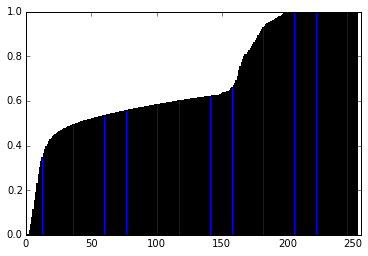

In [65]:
%%time
cumhist_np(im_orig.astype(int))

##1. HE_serial

In [30]:
def HE_serial(im_in):
    im = im_in.astype(int).copy()
    histogram = [0]*256
    height, width = im.shape
    for i in im:
        for j in i:
            histogram[j] += 1
    histogram = np.array(histogram, dtype=float)/(width*height)
    cum_hist = np.cumsum(histogram)
    equal_hist = (cum_hist*256).astype(int)
    mapfunc = dict(zip(range(256), equal_hist))
    new_im = np.zeros_like(im)
    for i in range(height):
        for j in range(width):
            new_im[i,j] = mapfunc[im[i,j]]
    
    return new_im

In [31]:
%%time
he_serial_orig = HE_serial(im_orig)

CPU times: user 11.9 s, sys: 313 ms, total: 12.2 s
Wall time: 12.1 s


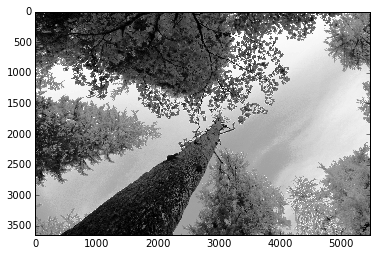

In [32]:
gshow(he_serial_orig)
scipy.misc.imsave('he_serial_orig.jpg', he_serial_orig)

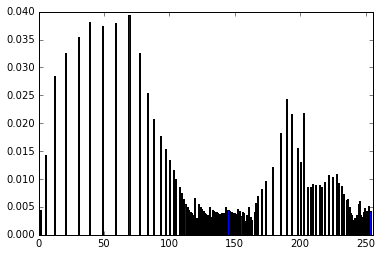

In [68]:
hist_np(he_numpy_orig)

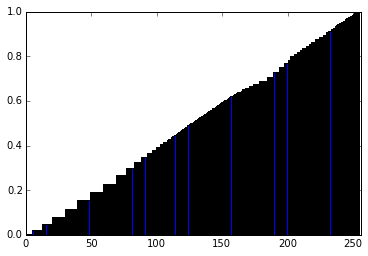

In [69]:
cumhist_np(he_numpy_orig)

In [33]:
%%time
he_serial_small = HE_serial(im_small)

CPU times: user 98.5 ms, sys: 6.86 ms, total: 105 ms
Wall time: 102 ms


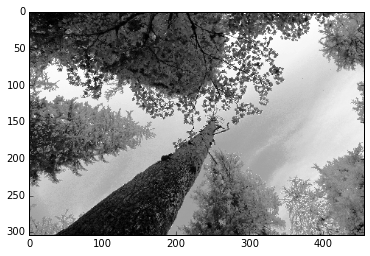

In [34]:
gshow(he_serial_small)
scipy.misc.imsave('he_serial_small.jpg', he_serial_small)

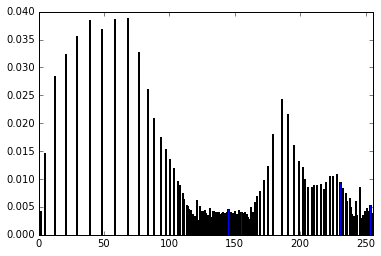

In [73]:
hist_np(he_serial_small)

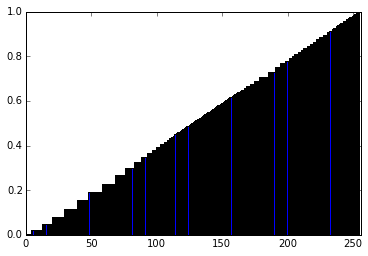

In [74]:
cumhist_np(he_serial_small)

##2. HE_numpy

In [35]:
def HE_numpy(im_input,nbr_bins=256):
    im = im_input.astype(int)
    #get image histogram
    imhist,bins = np.histogram(im.flatten(),nbr_bins,normed=True)
    cdf = imhist.cumsum() #cumulative distribution function
    cdf = 255 * cdf / cdf[-1] #normalize

    #use linear interpolation of cdf to find new pixel values
    im2 = np.interp(im.flatten(),bins[:-1],cdf)

    return im2.reshape(im.shape)

In [36]:
%%time
he_numpy_orig = HE_numpy(im_orig)

CPU times: user 847 ms, sys: 294 ms, total: 1.14 s
Wall time: 1.16 s


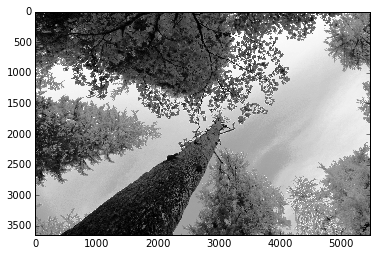

In [37]:
gshow(he_numpy_orig)
scipy.misc.imsave('he_numpy_orig.jpg', he_numpy_orig)

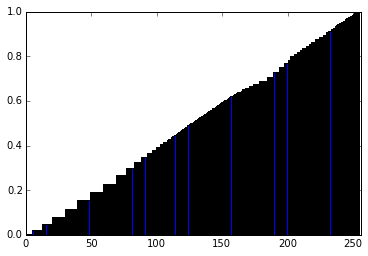

In [72]:
cumhist_np(he_numpy_orig)

In [38]:
%%time
he_numpy_small = HE_numpy(im_small)

CPU times: user 8.58 ms, sys: 4.94 ms, total: 13.5 ms
Wall time: 11.8 ms


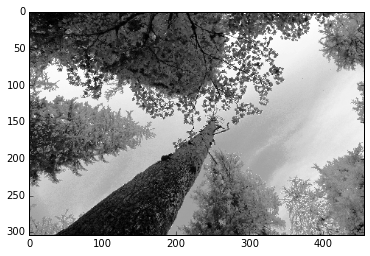

In [39]:
gshow(he_numpy_small)
scipy.misc.imsave('he_numpy_small.jpg', he_numpy_small)

##3. LHE_serial

In [40]:
def LHE_serial(im_input):
    gain = lambda s,A,S0: A-A/S0*s if A-A/S0*s>1 else 1
    im = im_input.astype(int).copy()
    height, width = im.shape
    im = np.pad(im, 4, mode='edge')
    new = np.zeros([height,width])
    for h in range(4,height+4):
        for w in range(4, width+4):
            window = im[h-4:h+5,w-4:w+5]
            old = im[h,w]
            M = np.mean(window)
            S = np.std(window)
            G = gain(S,20,10)
#             B = 0
#             if S*G-M>0:
#                 B = G*S-M
#             if S*G+M>255:
#                 B =(M+G*S)-255
            B=(128-M)*0.25
            N = (old-M)*G+B+M
            #if w==20:
                #print old,M,S,G,B,N
            if N>255:
                new[h-4,w-4]=255
            elif N<0:
                new[h-4,w-4]=0
            else:
                new[h-4,w-4]=N
    return new.astype(int)

In [41]:
%%time
lhe_serial_small = LHE_serial(im_small)

CPU times: user 5.33 s, sys: 74.6 ms, total: 5.4 s
Wall time: 5.39 s


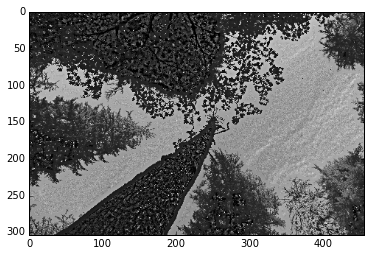

In [42]:
gshow(lhe_serial_small)
scipy.misc.imsave('lhe_serial_small.jpg', lhe_serial_small)

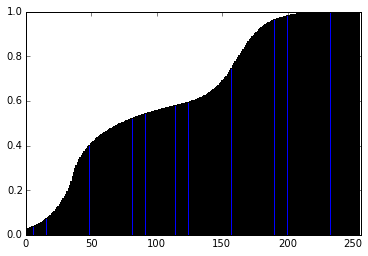

In [75]:
cumhist_np(lhe_serial_small)

##4. AHE serial

In [43]:
def AHE_serial(im_input, windowwidth=21):
    im = im_input.astype(int).copy()
    height, width = im.shape
    new = np.zeros([height,width])
    d = windowwidth/2
    
    for h in range(height):
        for w in range(width):
            cur = im[h,w]
            window = im[h-d if h-d>-1 else 0:h+d+1 if h+d+1<height else height,
                        w-d if w-d>-1 else 0:w+d+1 if w+d+1<width else width]
            flat = [i for sub in window for i in sub]
            flat = flat + random.sample(flat+flat+flat+flat, windowwidth*windowwidth-len(flat))
            idx = np.sort(np.array(flat)).tolist().index(cur)
            
            new[h,w] = int(idx*1.0/windowwidth/windowwidth*256)
    return new

In [44]:
%%time
ahe_serial_small = AHE_serial(im_small)

CPU times: user 23.2 s, sys: 154 ms, total: 23.4 s
Wall time: 23.7 s


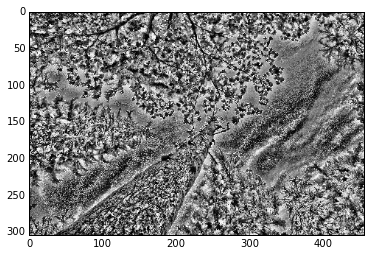

In [45]:
gshow(ahe_serial_small)
scipy.misc.imsave('ahe_serial_small.jpg', ahe_serial_small)

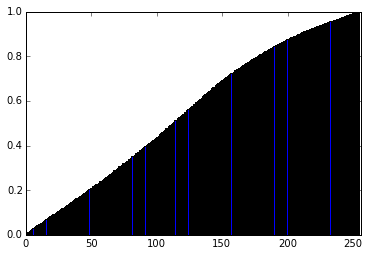

In [76]:
cumhist_np(ahe_serial_small)

##5. AHE_CL_buffer

In [53]:
def run_AHE_cl(img,clfile = 'HE.cl',windowsize=21,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()

    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)
    
    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'This context is associated with ', len(context.devices), 'devices'
        print 'The queue is using the device:', queue.device.name



    program = cl.Program(context, open(clfile).read()).build(options='')
    
    AHE_out = np.zeros_like(img)

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, AHE_out.size * 4)

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])


    pad_size = np.int32(windowsize/2)
    # Set up a (N+8 x N+8) local memory buffer.
    # +2 for 1-pixel halo on all sides, 4 bytes for float.
    local_memory = cl.LocalMemory(4 * (local_size[0] + pad_size) * (local_size[1] + pad_size))
    # Each work group will have its own private buffer.
    buf_width = np.int32(local_size[0] + 2*pad_size)
    buf_height = np.int32(local_size[1] + 2*pad_size)
    halo = np.int32(pad_size)

    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])

    #max_iters = np.int32(1024)

    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)

    event = program.AHE_buffer(queue, global_size, local_size,
                           gpu_im, gpu_out, local_memory,
                           width, height,
                           buf_width, buf_height, halo,2*pad_size+1)

    cl.enqueue_copy(queue, AHE_out, gpu_out, is_blocking=True)

    seconds = (event.profile.end - event.profile.start) / 1e9

    gshow(AHE_out.astype(int))
    print "------------------------------------------"
    print "AHE serial image with size: ", img.shape
    print "Window size: ", windowsize
    print "Used time: ", seconds
    print "------------------------------------------"
    
    return AHE_out

------------------------------------------
AHE serial image with size:  (304, 456)
Window size:  21
Used time:  0.00860624
------------------------------------------


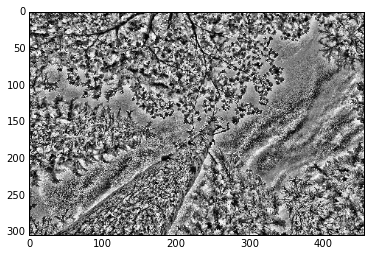

In [54]:
ahe_cl_small = run_AHE_cl(im_small)

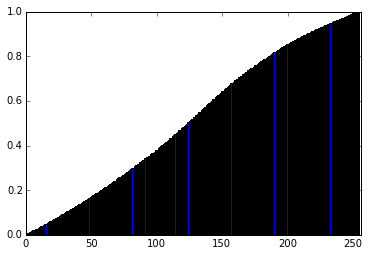

In [77]:
cumhist_np(ahe_cl_small)

In [55]:
scipy.misc.imsave('ahe_cl_small.jpg', ahe_cl_small)

------------------------------------------
AHE serial image with size:  (3648, 5472)
Window size:  21
Used time:  0.76763072
------------------------------------------


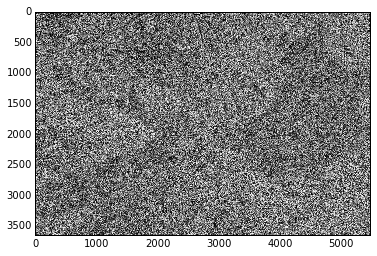

In [56]:
ahe_cl_orig = run_AHE_cl(im_orig)

In [57]:
scipy.misc.imsave('ahe_cl_orig.jpg', ahe_cl_orig)

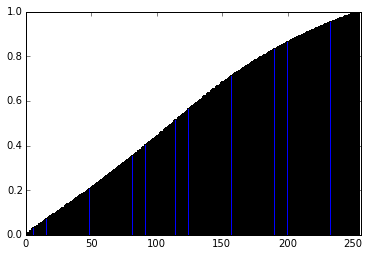

In [79]:
cumhist_np(ahe_cl_orig)

##6. AHE_interpolation

In [150]:
def run_AHE_Interpolation_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    #local_memory = cl.LocalMemory(4 * local_size[0]*local_size[1])
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Used time: 1. histogram calculation: ", time1
    print "Used time: 2. transformation: ", time2
    print "------------------------------------------"
    
    return img_out, cumsumhist

(12, 3072)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time: 1. histogram calculation:  0.37129248
Used time: 2. transformation:  0.01642072
------------------------------------------


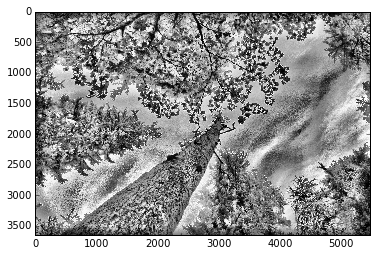

In [236]:
ahe_inter = run_AHE_Interpolation_cl(im_orig)

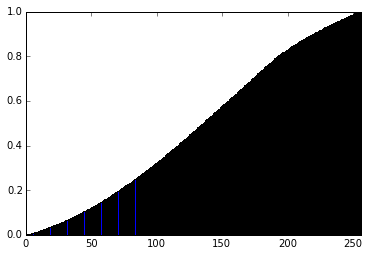

In [83]:
cumhist_np(ahe_inter[0])

(2, 512)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time:  0.46128696
------------------------------------------


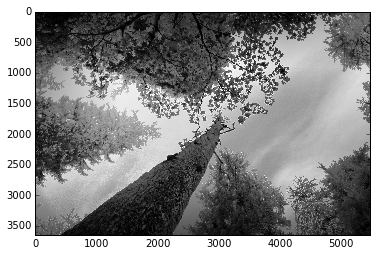

In [81]:
ahe_inter2 = run_AHE_Interpolation_cl(im_orig,segmentationsize=2)

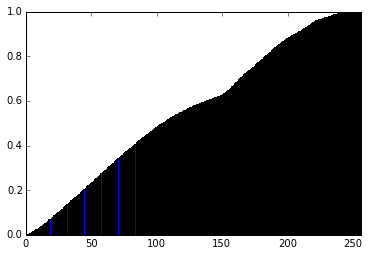

In [109]:
cumhist_np(ahe_inter2[0]/np.max(ahe_inter2[0])*256)

(1, 256)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time:  0.45597288
------------------------------------------


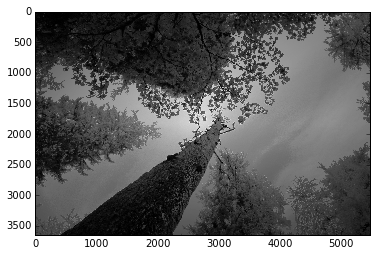

In [113]:
ahe_inter1 = run_AHE_Interpolation_cl(im_orig,segmentationsize=1)

In [115]:
np.max(ahe_inter1[0])

36310.363

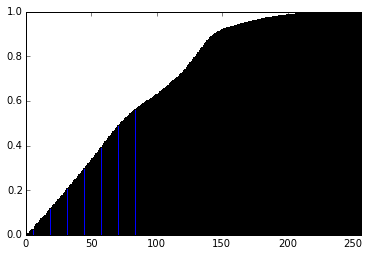

In [114]:
cumhist_np(ahe_inter1[0]/np.max(ahe_inter1[0])*256)

(24, 6144)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time:  0.30538152
------------------------------------------


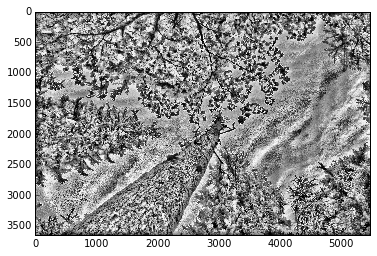

In [116]:
ahe_inter24 = run_AHE_Interpolation_cl(im_orig,segmentationsize=24)

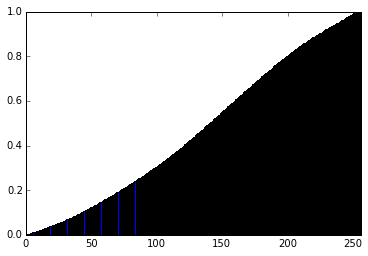

In [117]:
cumhist_np(ahe_inter24[0]/np.max(ahe_inter24[0])*256)

(8, 2048)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time: 1. histogram calculation:  0.41600448
Used time: 2. transformation:  0.01727568
------------------------------------------


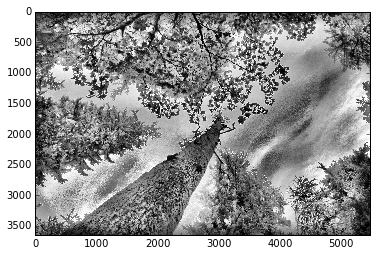

In [123]:
ahe_inter8 = run_AHE_Interpolation_cl(im_orig,segmentationsize=8)

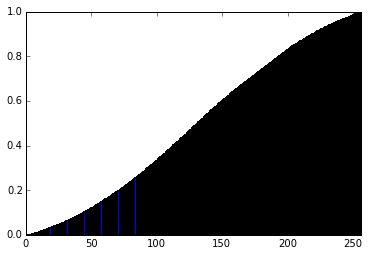

In [121]:
cumhist_np(ahe_inter8[0]/np.max(ahe_inter8[0])*256)

(12, 3072)
------------------------------------------
AHE serial on image with size:  (304, 456)
Used time: 1. histogram calculation:  0.00101272
Used time: 2. transformation:  0.00015224
------------------------------------------


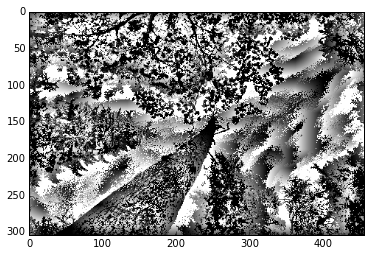

In [153]:
ahe_inter_12_small = run_AHE_Interpolation_cl(im_small)

In [148]:
ahe_inter_12_small[0]

array([[ 0.25      ,  0.2631579 ,  0.        , ...,  0.42105263,
         0.44736841,  0.47368422],
       [ 0.        ,  0.2842105 ,  0.29842103, ...,  0.42105263,
         0.44736841,  0.75789469],
       [ 0.28999999,  0.30526316,  0.3205263 , ...,  0.42105263,
         0.44736841,  0.77894735],
       ..., 
       [ 0.5       ,  0.47368419,  0.        , ...,  0.26631582,
         0.25421056,  0.24210529],
       [ 0.5       ,  0.47368419,  0.44736844, ...,  0.24315791,
         0.        ,  0.        ],
       [ 0.5       ,  0.47368419,  0.44736844, ...,  0.        ,
         0.        ,  0.        ]], dtype=float32)

##7. Interpolation buffer

In [154]:
def run_AHE_Interpolation_buffer_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(256*4*4+2*4) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Used time: 1. histogram calculation: ", time1
    print "Used time: 2. transformation: ", time2
    print "Used time: 3. total: ", time1+time2
    print "------------------------------------------"
    
    return img_out, cumsumhist

(12, 3072)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time: 1. histogram calculation:  0.37522352
Used time: 2. transformation:  1.082036
Used time: 3. total:  1.45725952
------------------------------------------


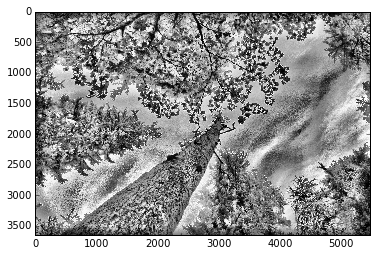

In [235]:
ahe_inter_buffer = run_AHE_Interpolation_buffer_cl(im_orig,segmentationsize=12)

##8. Better data structure

In [240]:
def run_AHE_Interpolation_buffer_smaller_cl(img,clfile = 'AHE_interpolation.cl',segmentationsize=12,suppressprint=True):
    '''
    1). Setting up OpenCL environment with the specified cl file.
    '''
    #################################
    # Setting up environment
    #################################
    # List our platforms
    platforms = cl.get_platforms()


    # Create a context with all the devices
    devices = platforms[0].get_devices()
    context = cl.Context(devices)


    # Create a queue for transferring data and launching computations.
    # Turn on profiling to allow us to check event times.
    queue = cl.CommandQueue(context, context.devices[0],
                            properties=cl.command_queue_properties.PROFILING_ENABLE)
    
    if(not suppressprint):
        print 'The platforms detected are:'
        print '---------------------------'
        for platform in platforms:
            print platform.name, platform.vendor, 'version:', platform.version

        print 'This context is associated with ', len(context.devices), 'devices'
        # List devices in each platform
        for platform in platforms:
            print 'The devices detected on platform', platform.name, 'are:'
            print '---------------------------'
            for device in platform.get_devices():
                print device.name, '[Type:', cl.device_type.to_string(device.type), ']'
                print 'Maximum clock Frequency:', device.max_clock_frequency, 'MHz'
                print 'Maximum allocable memory size:', int(device.max_mem_alloc_size / 1e6), 'MB'
                print 'Maximum work group size', device.max_work_group_size
                print '---------------------------'
        print 'The queue is using the device:', queue.device.name

    program = cl.Program(context, open(clfile).read()).build(options='')
    
    width = np.int32(img.shape[1])
    height = np.int32(img.shape[0])
    
    
    n_seg = width*height/segmentationsize/segmentationsize
    seg_width = np.int32(width/segmentationsize)
    seg_height = np.int32(height/segmentationsize)
    # every segmentation requires 256 bins
    #hist_mapping = np.array([0]*(n_seg*256))
    hist_mapping = np.zeros([segmentationsize,256*segmentationsize]).astype(np.int32)
    

    gpu_im = cl.Buffer(context, cl.mem_flags.READ_ONLY, img.size * 4)
    # buffer histogram storage
    gpu_hist = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, hist_mapping.size * 4)
    

    local_size = (8, 8)  # 64 pixels per work group
    global_size = tuple([round_up(g, l) for g, l in zip(img.shape[::-1], local_size)])
    
    
    
    cl.enqueue_copy(queue, gpu_im, img, is_blocking=False)
    
    
    event1 = program.AHE_interpolation_hist(queue, global_size, local_size,
                                           gpu_im, gpu_hist,
                                           width, height, seg_width,seg_height)
    
    cl.enqueue_copy(queue, hist_mapping, gpu_hist, is_blocking=True)
    
    time1 = (event1.profile.end - event1.profile.start) / 1e9

    img_out = np.zeros_like(img, dtype=np.float32)
    gpu_out = cl.Buffer(context, cl.mem_flags.WRITE_ONLY, img_out.size * 4)
    print hist_mapping.shape
    hist_norm = (hist_mapping.astype(np.float32)/(im_orig.size/144)).reshape([segmentationsize, segmentationsize, 256])
    cumsumhist = np.array([[i.cumsum()*256 for i in sub] for sub in hist_norm ], dtype=np.int32)
    
    gpu_cumhist = cl.Buffer(context, cl.mem_flags.READ_ONLY, cumsumhist.size * 4)
    
    local_memory = cl.LocalMemory(32*4+2) # store the mapping histogram into the buffer
    
    
    cl.enqueue_copy(queue, gpu_cumhist, cumsumhist, is_blocking=False)
    event2 = program.AHE_interpolation_transform_buffer_small(queue, global_size, local_size,
                                           gpu_im, gpu_cumhist, gpu_out, local_memory,
                                           width, height,seg_width,seg_height)
    
    cl.enqueue_copy(queue, img_out, gpu_out, is_blocking=True)
    
    time2 = (event2.profile.end - event2.profile.start) / 1e9
    
    gshow(normalize(img_out).astype(int))
    print "------------------------------------------"
    print "AHE serial on image with size: ", img.shape
    print "Used time: 1. histogram calculation: ", time1
    print "Used time: 2. transformation: ", time2
    print "Used time: 3. total: ", time1+time2
    print "------------------------------------------"
    
    return img_out, cumsumhist

(12, 3072)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time: 1. histogram calculation:  0.3801516
Used time: 2. transformation:  0.29054232
Used time: 3. total:  0.67069392
------------------------------------------


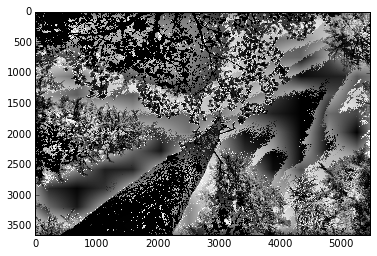

In [254]:
ahe_inter_buffer_small = run_AHE_Interpolation_buffer_smaller_cl(im_orig)

##Appendix

In [156]:
from skimage import io, color

In [157]:
rgb = io.imread('../test_large.JPG')
lab = color.rgb2lab(rgb)

In [161]:
im_orig

array([[  3.05999994,   3.05999994,   3.05999994, ...,  61.66799927,
         56.66799927,  50.66799927],
       [  3.05999994,   3.05999994,   3.05999994, ...,  60.15200043,
         56.15200043,  55.15200043],
       [  3.05999994,   3.05999994,   3.05999994, ...,  60.15200043,
         55.86399841,  58.86399841],
       ..., 
       [ 86.00900269,  78.27999878,  64.77899933, ...,  12.0170002 ,
         11.72900009,  11.72900009],
       [ 78.86100006,  67.3769989 ,  55.76200104, ...,  10.0170002 ,
         10.13099957,  10.13099957],
       [ 67.05000305,  55.68000031,  45.19599915, ...,   8.13099957,
          8.13099957,   7.13100004]], dtype=float32)

In [204]:
lab[:,:,0]

array([[ 37.82424861,  36.56670136,  35.72414946, ...,  47.34897648,
         47.28526712,  46.88546607],
       [ 37.40589037,  36.14585084,  35.30158679, ...,  47.34897648,
         47.28526712,  47.28526712],
       [ 36.56670136,  35.72414946,  34.87815216, ...,  47.7484983 ,
         47.68446758,  47.68446758],
       ..., 
       [ 49.30485699,  55.45855565,  56.15295223, ...,  46.380293  ,
         45.97718631,  45.97718631],
       [ 46.50255458,  53.11282556,  56.23617854, ...,  47.58574026,
         46.78275009,  46.78275009],
       [ 47.70730243,  52.471221  ,  54.67881279, ...,  49.1841922 ,
         48.38620534,  48.38620534]])

In [200]:
def color_img_transform(CE_gray, original_img='../test_large.JPG'):
    rgb = io.imread(original_img)
    lab = color.rgb2lab(rgb)
    spread = np.max(lab)-np.min(lab)
    new_lab = lab.copy()
    print 'lab transformation ready.'
    for h in range(len(new_lab)):
        for w in range(len(new_lab[h])):
            new_lab[h,w,0] = float(CE_gray[h,w])/256*spread
        if h%100==0:
            print 'on row', h
    return color.lab2rgb(new_lab)

In [183]:
def get_luminance_mat(original_img='../test_large.JPG'):
    rgb = io.imread(original_img)
    lab = color.rgb2lab(rgb)
    new = np.array([i[0] for row in lab for i in row])
    return new.reshape(lab.shape[0], lab.shape[1])

In [184]:
temp = get_luminance_mat()

(12, 3072)
------------------------------------------
AHE serial on image with size:  (3648, 5472)
Used time: 1. histogram calculation:  0.36296576
Used time: 2. transformation:  0.01706368
------------------------------------------


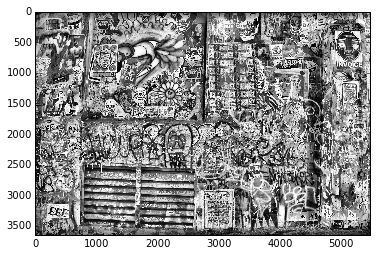

In [194]:
temp_trans = run_AHE_Interpolation_cl(temp.astype(np.float32))

In [216]:
temp_color = color_img_transform_2(temp_trans[0])

48.2983342692
lab transformation ready.


In [214]:
np.min(temp_trans[0])

0.0

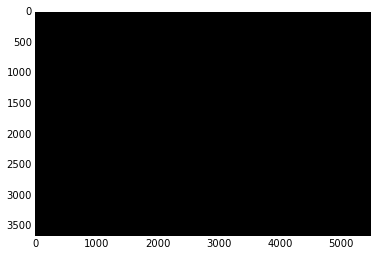

In [217]:
gshow(temp_color)

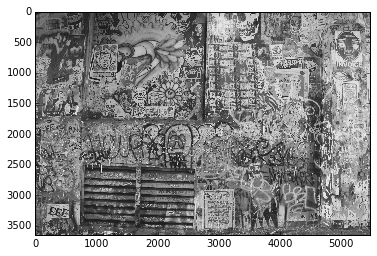

In [185]:
gshow(temp)

In [174]:
color_ahe = color_img_transform(ahe_inter[0])

lab transformation ready.
on row 0
on row 100
on row 200
on row 300
on row 400
on row 500
on row 600
on row 700
on row 800
on row 900
on row 1000
on row 1100
on row 1200
on row 1300
on row 1400
on row 1500
on row 1600
on row 1700
on row 1800
on row 1900
on row 2000
on row 2100
on row 2200
on row 2300
on row 2400
on row 2500
on row 2600
on row 2700
on row 2800
on row 2900
on row 3000
on row 3100
on row 3200
on row 3300
on row 3400
on row 3500
on row 3600


/Users/haosutang/anaconda/lib/python2.7/site-packages/skimage/color/colorconv.py:864: UserWarning: Color data out of range: Z < 0 in 470 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


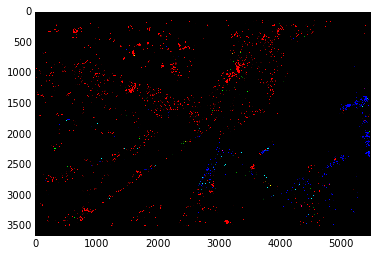

In [175]:
show(color_ahe)